Interpolando campo en malla regular (r, θ, φ)...
Interpolación completada.


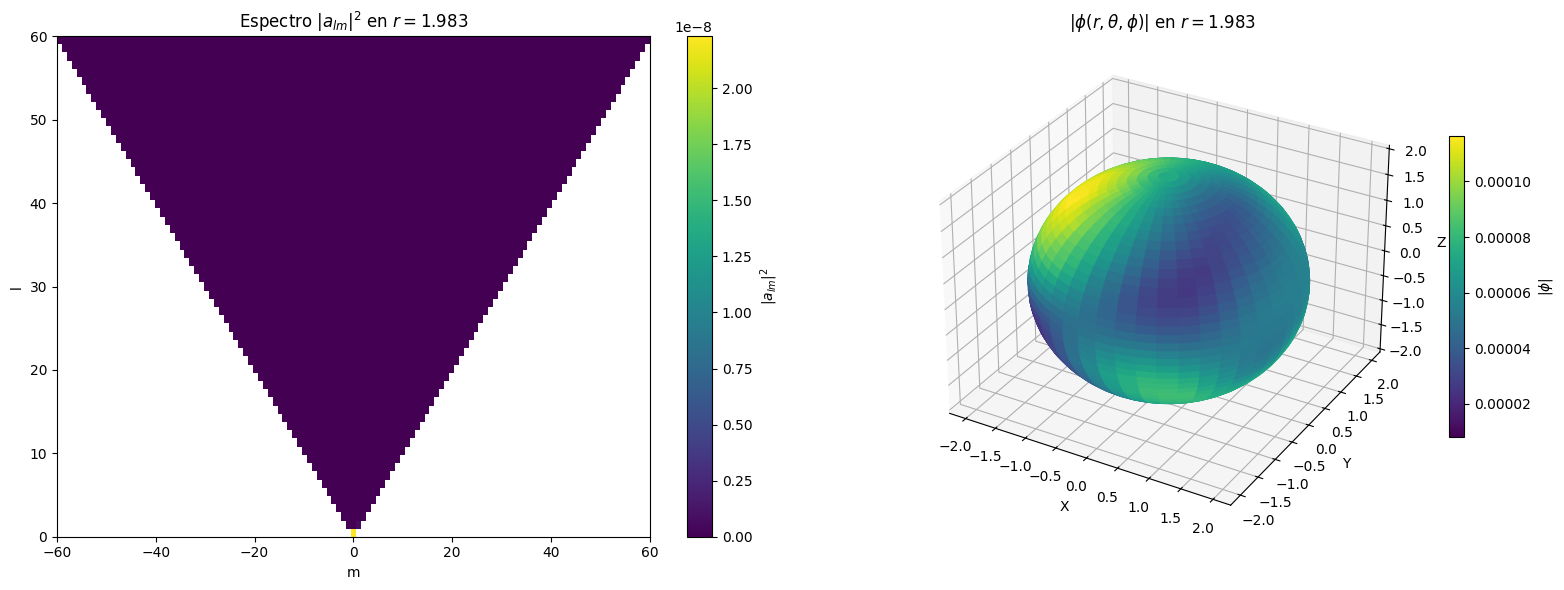

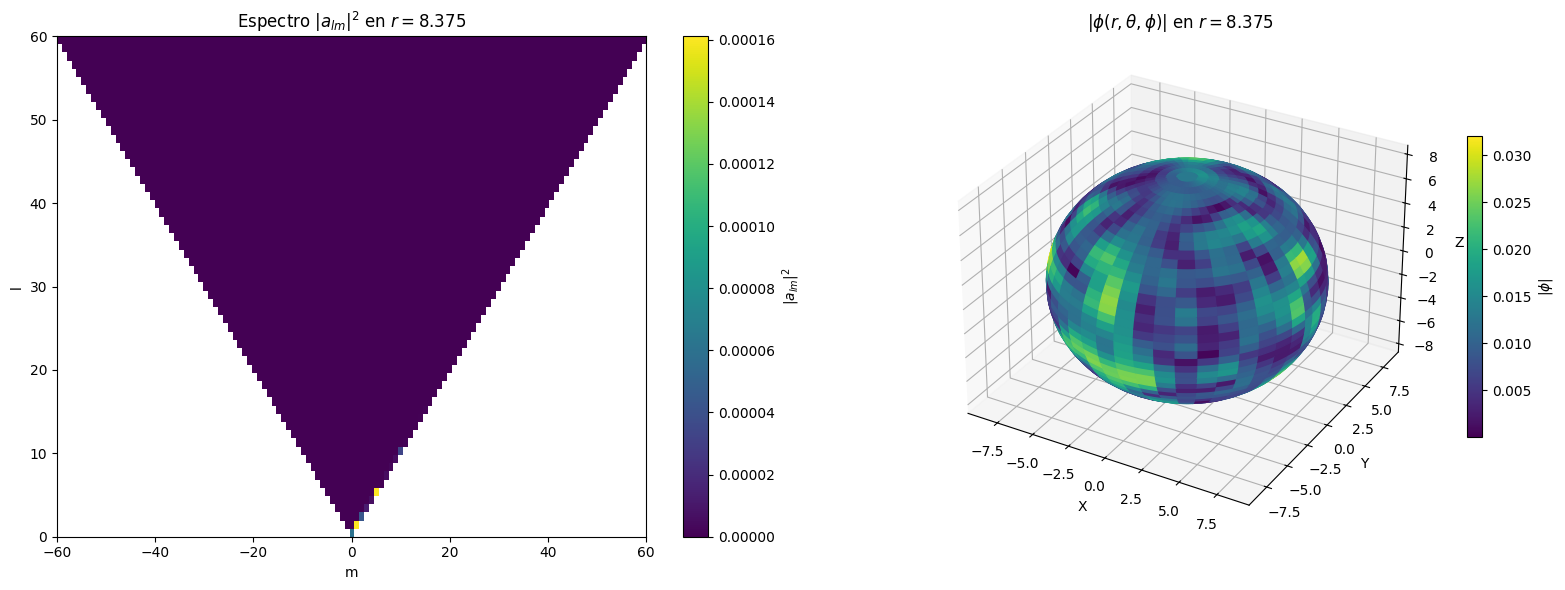

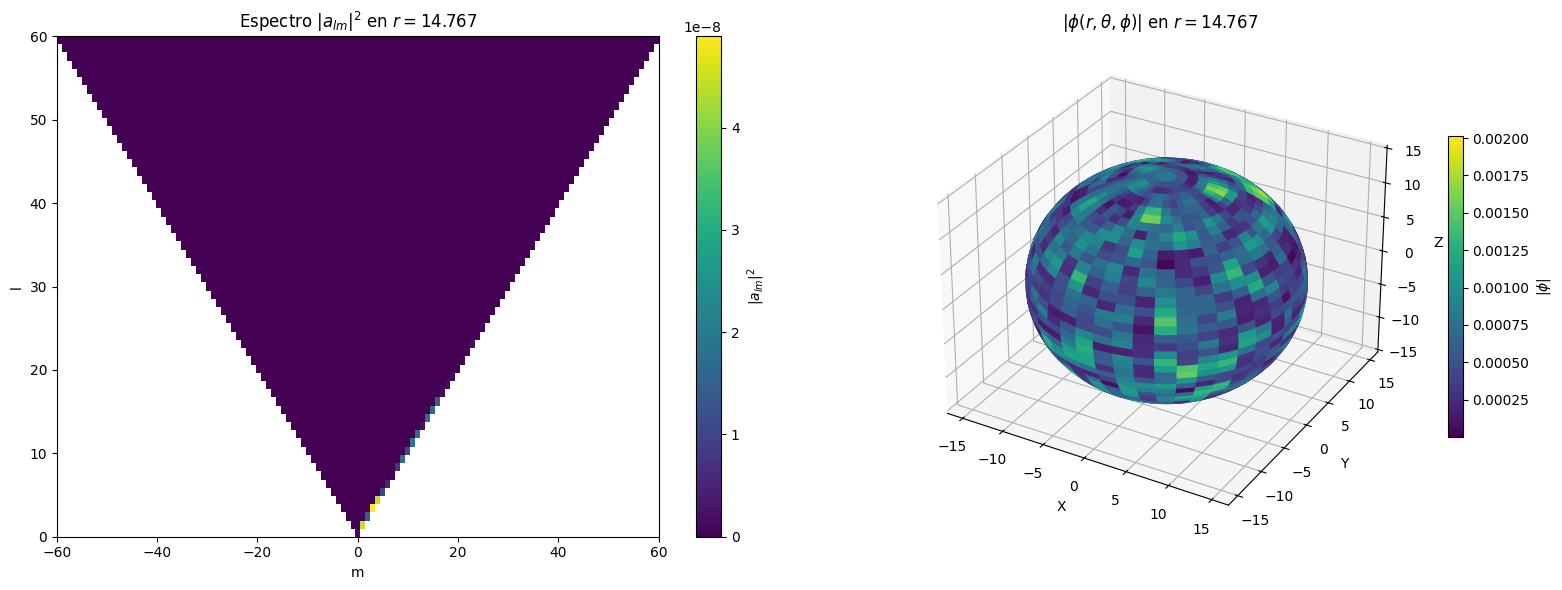

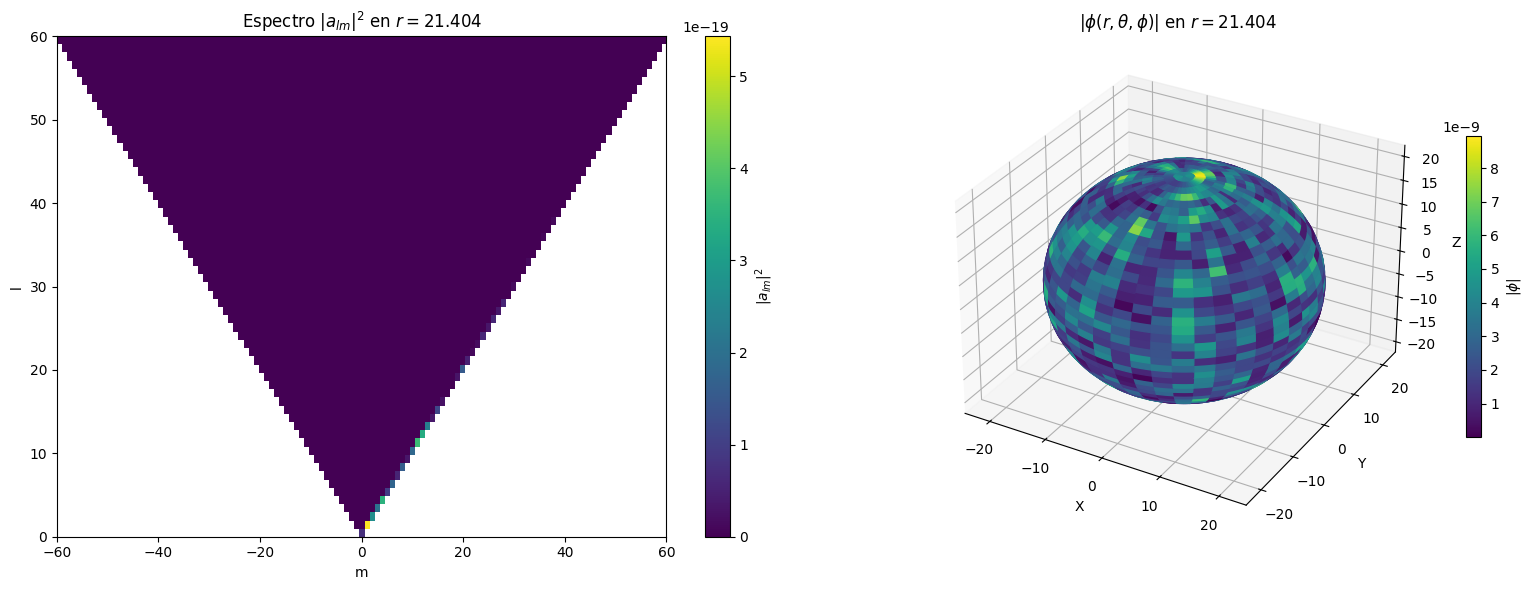

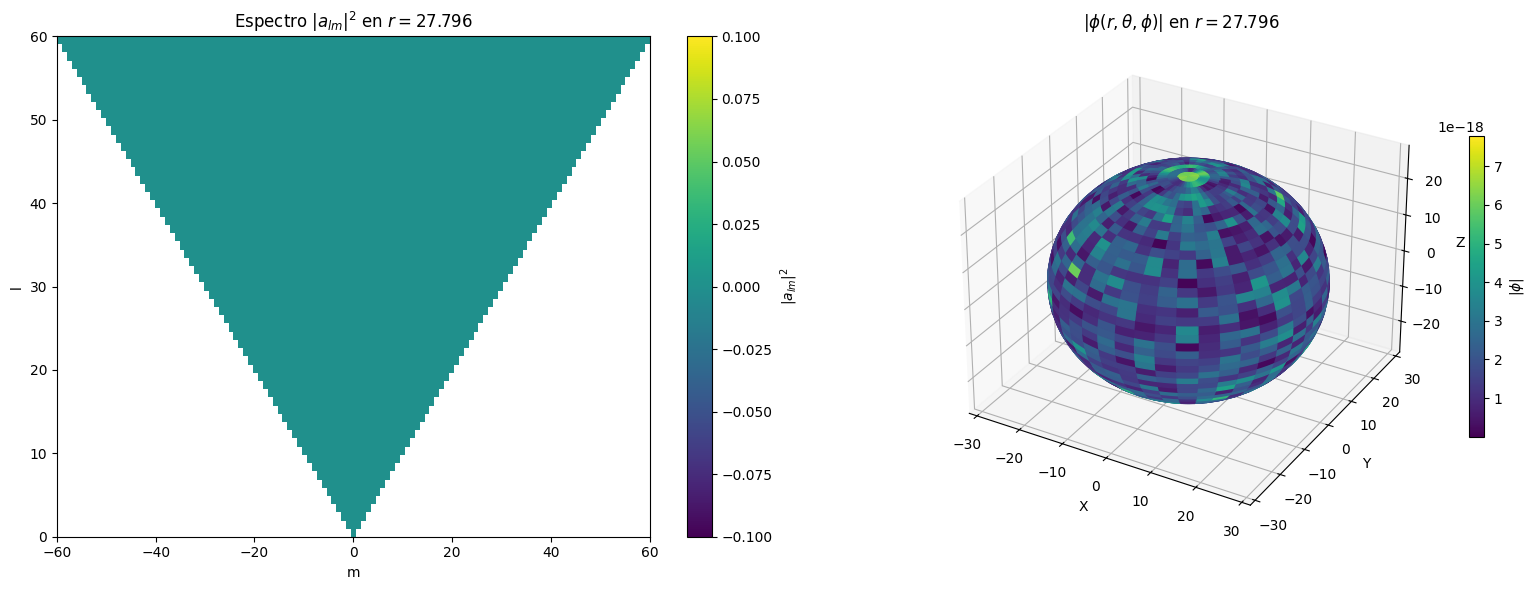

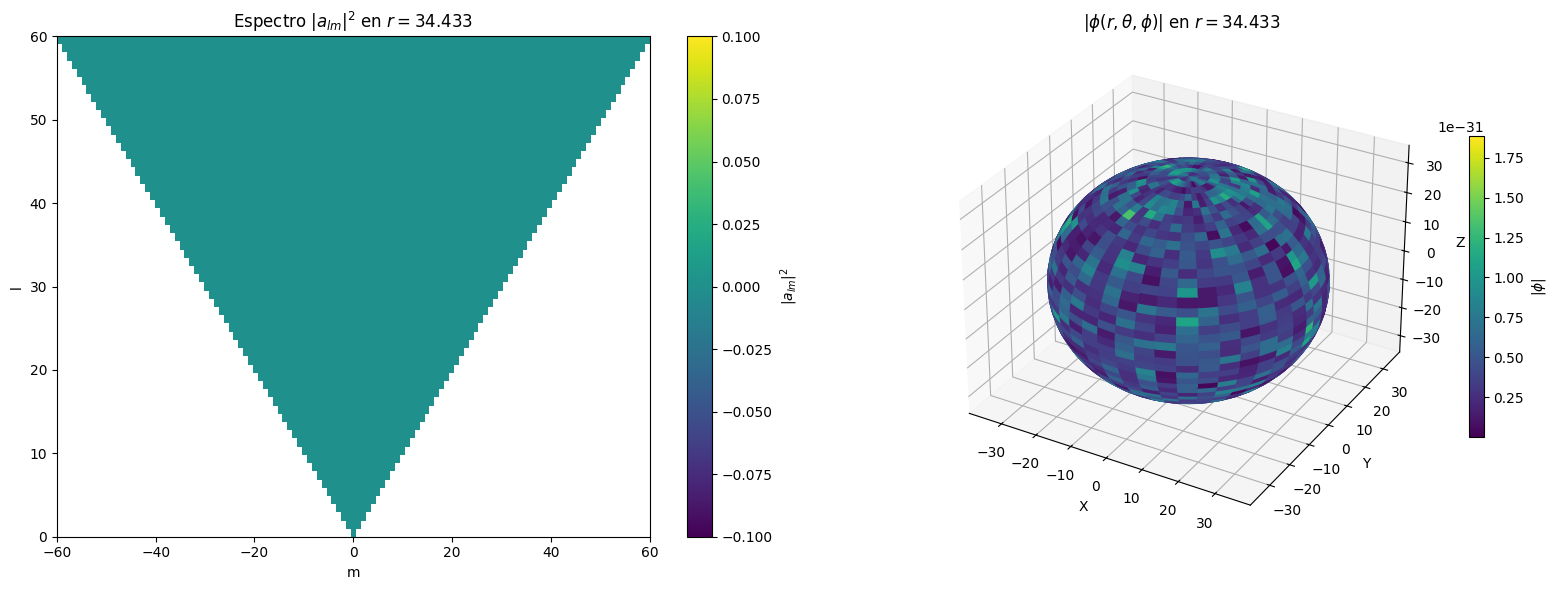

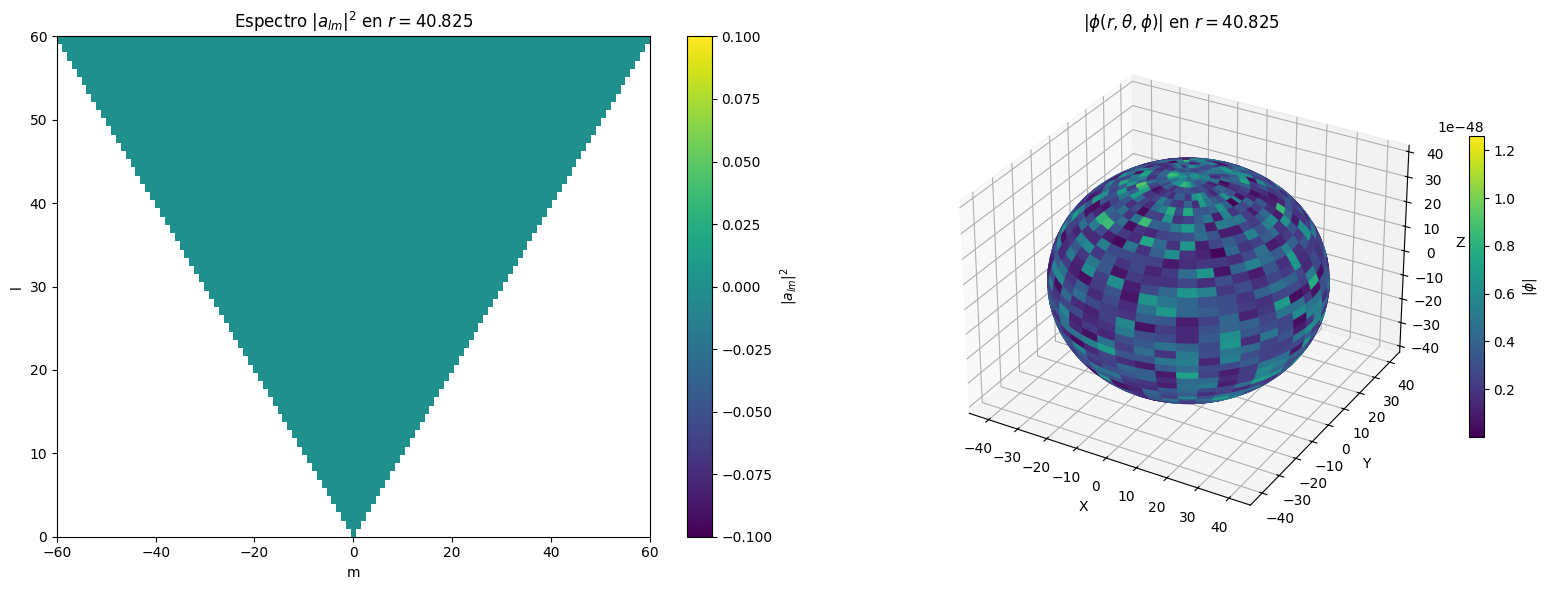

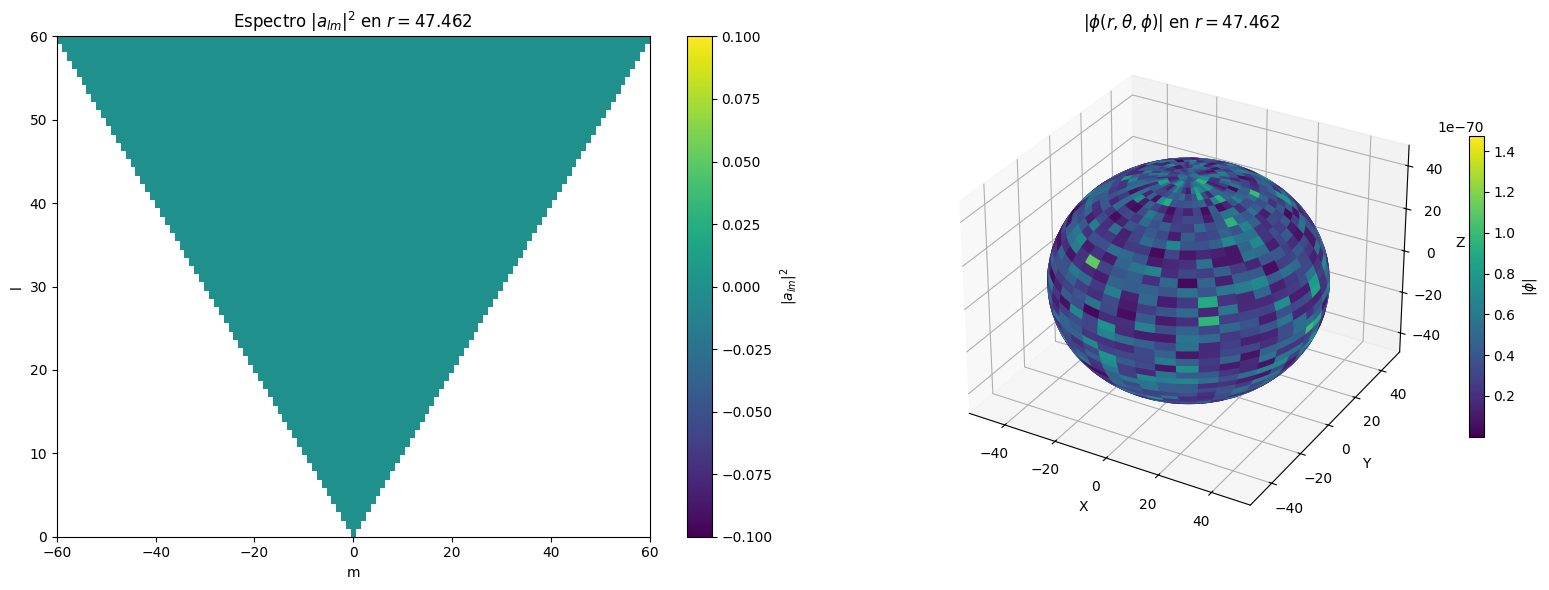

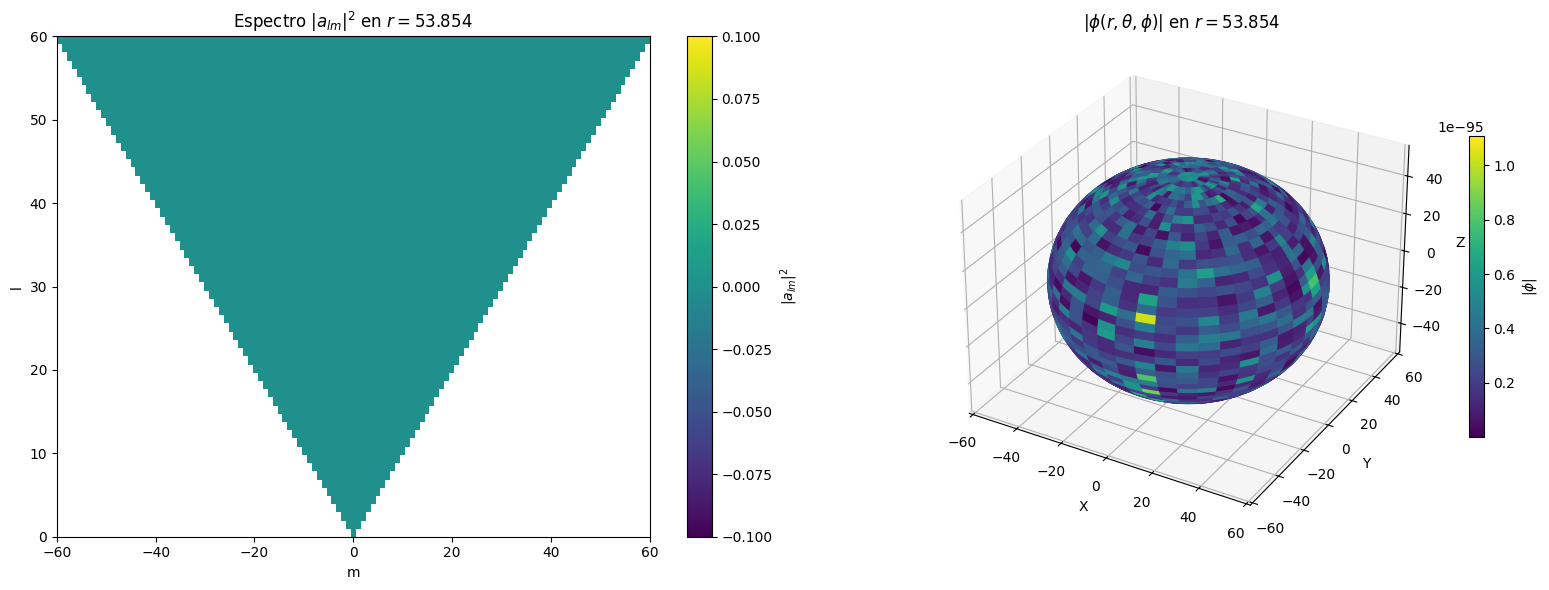

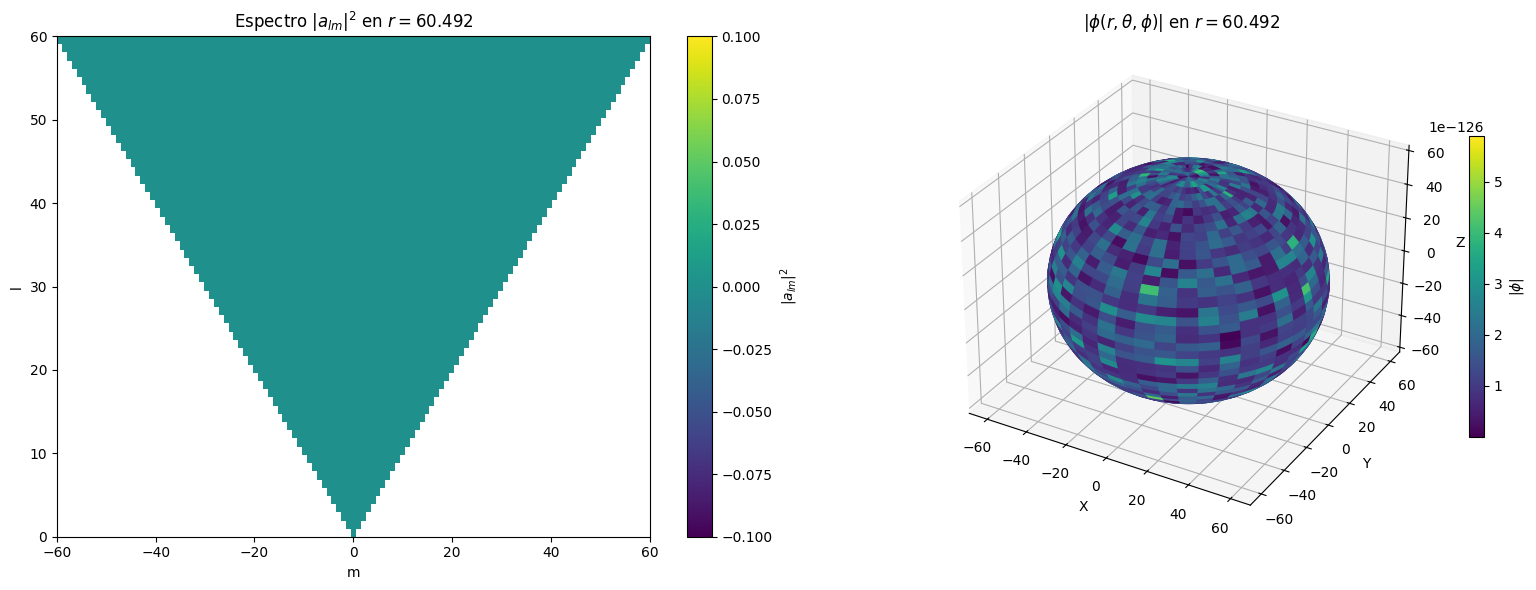

In [24]:
import numpy as np
from scipy.special import sph_harm_y
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import trapezoid as trapz
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py

# === Configuración ===
filename_real = '/home/flavio/Codes/KG/main/exe/test_6/rePhi.h5'
filename_imag = '/home/flavio/Codes/KG/main/exe/test_6/imPhi.h5'
groupname = '/refinement_1'
i_snapshot = 0

# Nueva resolución angular
Ntheta_new = 256
Nphi_new = 256

# === Leer coordenadas ===
with h5py.File(filename_real, 'r') as f:
    g = f[groupname]
    r = g["Xcoord"][:].transpose()[:, 0, 0]
    theta = g["Ycoord"][:].transpose()[0, :, 0]
    phi = g["Zcoord"][:].transpose()[0, 0, :]

# Eliminar duplicados en r
r_unique, r_indices = np.unique(r, return_index=True)
Nr = len(r_unique) - 1

# === Leer campo complejo y reordenar a (r, theta, phi) ===
with h5py.File(filename_real, 'r') as f:
    phi_real = f[groupname][f"rePhi_{i_snapshot}"][:].transpose()
with h5py.File(filename_imag, 'r') as f:
    phi_imag = f[groupname][f"imPhi_{i_snapshot}"][:].transpose()

phi_data = phi_real + 1j * phi_imag
phi_data = phi_data[r_indices, :, :]  # aplicar filtro en r

# === Crear nueva malla angular y coordenadas ===
theta_new = np.linspace(0, np.pi, Ntheta_new + 1)
phi_new = np.linspace(0, 2 * np.pi, Nphi_new + 1)
r_interp = r_unique  # usamos mismos valores en r

# === Interpolación del campo en la nueva malla ===
interp_real = RegularGridInterpolator((r_unique, theta, phi), phi_data.real, bounds_error=False, fill_value=0.0)
interp_imag = RegularGridInterpolator((r_unique, theta, phi), phi_data.imag, bounds_error=False, fill_value=0.0)

print("Interpolando campo en malla regular (r, θ, φ)...")
R, Theta, Phi = np.meshgrid(r_interp, theta_new, phi_new, indexing='ij')
points = np.stack([R.ravel(), Theta.ravel(), Phi.ravel()], axis=-1)
phi_interp_flat = interp_real(points) + 1j * interp_imag(points)
phi_data_interp = phi_interp_flat.reshape((len(r_interp), len(theta_new), len(phi_new)))
print("Interpolación completada.")

x = R * np.sin(Theta) * np.cos(Phi)
y = R * np.sin(Theta) * np.sin(Phi)
z = R * np.cos(Theta)


# === Parámetros ===
l_max = 60
Nr = phi_data_interp.shape[0]
Ntheta = len(theta_new)
Nphi = len(phi_new)
i_r = np.linspace(4, Nr - 1, 10, dtype=int)

theta_grid, phi_grid = np.meshgrid(theta_new, phi_new, indexing='ij')
Ylm = np.zeros((l_max+1, 2*l_max+1, Ntheta, Nphi), dtype=complex)
for l in range(l_max + 1):
    for m in range(-l, l + 1):
        Ylm[l, m + l_max] = sph_harm_y(m, l, theta_grid, phi_grid)

for idx, ir in enumerate(i_r):
    alm = np.zeros((l_max+1, 2*l_max+1), dtype=complex)
    for l in range(l_max+1):
        for m in range(-l, l+1):
            integrando = phi_data_interp[ir, :, :] * np.conj(Ylm[l, m + l_max]) * np.sin(theta_new[:, None])
            alm[l, m + l_max] = trapz(trapz(integrando, phi_new, axis=1), theta_new, axis=0)
            if abs(alm[l, m+l_max]) <= 1e-10:
                alm[l, m+l_max] = 0.0 + 0j  # Evitar valores muy pequeños

    # Construye la matriz triangular de |a_lm|^2
    spec = np.full((l_max+1, 2*l_max+1), np.nan)
    for l in range(l_max+1):
        for m in range(-l, l+1):
            spec[l, m+l_max] = np.abs(alm[l, m+l_max])**2

    fig = plt.figure(figsize=(16, 6))

    # Primer subplot: espectro |a_lm|^2 (2D)
    ax0 = fig.add_subplot(1, 2, 1)
    im0 = ax0.imshow(spec, origin='lower', aspect='auto',
                    extent=[-l_max, l_max, 0, l_max], cmap='viridis')
    ax0.set_xlabel('m')
    ax0.set_ylabel('l')
    ax0.set_title(r'Espectro $|a_{{lm}}|^2$ en $r = {:.3f}$'.format(r_interp[ir]))
    plt.colorbar(im0, ax=ax0, label=r'$|a_{lm}|^2$')

    # Segundo subplot: superficie 3D con mapa de color
    ax1 = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax1.plot_surface(
        x[ir, :, :],
        y[ir, :, :],
        z[ir, :, :],
        facecolors=plt.cm.viridis(np.abs(phi_data_interp[ir, :, :]) / np.abs(phi_data_interp[ir, :, :]).max()),
        shade=False,
    )
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')
    ax1.set_title(r'$|\phi(r, \theta, \phi)|$ en $r = {:.3f}$'.format(r_interp[ir]))

    # Barra de color para la superficie
    mappable = mpl.cm.ScalarMappable(cmap='viridis')
    mappable.set_array(np.abs(phi_data_interp[ir, :, :]))
    plt.colorbar(mappable, ax=ax1, shrink=0.6, label=r'$|\phi|$')

    plt.tight_layout()
    plt.show()


In [22]:
import numpy as np
from scipy.special import sph_harm_y
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import trapezoid as trapz
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py

# === Configuración ===
filename_real = '/home/flavio/Codes/KG/main/exe/test_6/rePhi.h5'
filename_imag = '/home/flavio/Codes/KG/main/exe/test_6/imPhi.h5'
groupname = '/refinement_1'
i_snapshot = 0

# Nueva resolución angular
Ntheta_new = 128
Nphi_new = 128

# === Leer coordenadas ===
with h5py.File(filename_real, 'r') as f:
    g = f[groupname]
    r = g["Xcoord"][:].transpose()[:, 0, 0]
    theta = g["Ycoord"][:].transpose()[0, :, 0]
    phi = g["Zcoord"][:].transpose()[0, 0, :]

# Eliminar duplicados en r
r_unique, r_indices = np.unique(r, return_index=True)
Nr = len(r_unique) - 1

# === Leer campo complejo y reordenar a (r, theta, phi) ===
with h5py.File(filename_real, 'r') as f:
    phi_real = f[groupname][f"rePhi_{i_snapshot}"][:].transpose()
with h5py.File(filename_imag, 'r') as f:
    phi_imag = f[groupname][f"imPhi_{i_snapshot}"][:].transpose()

phi_data = phi_real + 1j * phi_imag
phi_data = phi_data[r_indices, :, :]  # aplicar filtro en r

# === Crear nueva malla angular y coordenadas ===
theta_new = np.linspace(0, np.pi, Ntheta_new + 1)
phi_new = np.linspace(0, 2 * np.pi, Nphi_new + 1)
r_interp = r_unique  # usamos mismos valores en r

# === Interpolación del campo en la nueva malla ===
interp_real = RegularGridInterpolator((r_unique, theta, phi), phi_data.real, bounds_error=False, fill_value=0.0)
interp_imag = RegularGridInterpolator((r_unique, theta, phi), phi_data.imag, bounds_error=False, fill_value=0.0)

print("Interpolando campo en malla regular (r, θ, φ)...")
R, Theta, Phi = np.meshgrid(r_interp, theta_new, phi_new, indexing='ij')
points = np.stack([R.ravel(), Theta.ravel(), Phi.ravel()], axis=-1)
phi_interp_flat = interp_real(points) + 1j * interp_imag(points)
phi_data_interp = phi_interp_flat.reshape((len(r_interp), len(theta_new), len(phi_new)))
print("Interpolación completada.")

# === Parámetros ===
l_max = 200
Nr = phi_data_interp.shape[0]
Ntheta = len(theta_new)
Nphi = len(phi_new)
i_r = np.linspace(4, Nr - 1, 10, dtype=int)

theta_grid, phi_grid = np.meshgrid(theta_new, phi_new, indexing='ij')
Ylm = np.zeros((l_max+1, 2*l_max+1, Ntheta, Nphi), dtype=complex)
for l in range(l_max + 1):
    for m in range(-l, l + 1):
        Ylm[l, m + l_max] = sph_harm_y(m, l, theta_grid, phi_grid)

Pl_all = []
alm_all = []
for idx, ir in enumerate(i_r):
    print(f"Procesando radio {r_interp[ir]:.3f}...")
    alm = np.zeros((l_max+1, 2*l_max+1), dtype=complex)
    for l in range(l_max+1):
        for m in range(-l, l+1):
            integrando = phi_data_interp[ir, :, :] * np.conj(Ylm[l, m + l_max]) * np.sin(theta_new[:, None])
            alm[l, m + l_max] = trapz(trapz(integrando, phi_new, axis=1), theta_new, axis=0)
            if abs(alm[l, m+l_max]) < 1e-10:
                alm[l, m+l_max] = 1.e-10 + 0j  # Evitar valores muy pequeños

    # Construye la matriz triangular de |a_lm|^2
    spec = np.full((l_max+1, 2*l_max+1), np.nan)
    for l in range(l_max+1):
        for m in range(-l, l+1):
            spec[l, m+l_max] = np.abs(alm[l, m+l_max])**2
    
    P_l = np.zeros(l_max + 1)
    for l in range(l_max + 1):
        P_l[l] = np.sum(np.abs(alm[l, l_max - l:l_max + l + 1])**2)

    Pl_all.append(P_l)
    alm_all.append(alm)

# === Graficar espectros P_l ===
plt.figure(figsize=(10, 6))
for i, P_l in enumerate(Pl_all):
    plt.plot(np.arange(l_max + 1), P_l, label=f"$r = {r_interp[i_r[i]]:.2f}$")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$P_\ell = \sum_m |a_{\ell m}|^2$")
plt.title(f"Espectro angular $P_\ell$ para {len(i_r)} radios")
plt.legend(fontsize=8, loc='upper right', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

# === Graficar |a_lm|^2 para todos los radios detectores ===
for idx, ir in enumerate(i_r):
    alm = alm_all[idx]
    spec_log = np.where(np.isfinite(alm) & (alm > 0), alm, 1e-20)
    plt.figure(figsize=(12, 6))
    im = plt.imshow(np.log10(spec_log), origin='lower', aspect='auto',
                    extent=[-l_max, l_max, 0, l_max], cmap='viridis')
    plt.colorbar(im, label=r'$log_{10}(|a_{lm}|^2)$')
    plt.xlabel('m')
    plt.ylabel('l')
    plt.title(r'Espectro de armónicos esféricos $|a_{{lm}}|^2$ en $r = {:.3f}$'.format(r_interp[ir]))
    plt.tight_layout()
    plt.show()

Interpolando campo en malla regular (r, θ, φ)...
Interpolación completada.


KeyboardInterrupt: 

In [31]:
import numpy as np
from scipy.special import sph_harm_y
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import trapezoid as trapz
import matplotlib.pyplot as plt
import matplotlib as mpl
import h5py

# === Configuración ===
filename_real = '/home/flavio/Codes/KG/main/exe/test_6/rePhi.h5'
filename_imag = '/home/flavio/Codes/KG/main/exe/test_6/imPhi.h5'
groupname = '/refinement_1'
i_snapshot = 0

# Nueva resolución angular
Ntheta_new = 100
Nphi_new = 100

# === Leer coordenadas ===
with h5py.File(filename_real, 'r') as f:
    g = f[groupname]
    r = g["Xcoord"][:].transpose()[:, 0, 0]
    theta = g["Ycoord"][:].transpose()[0, :, 0]
    phi = g["Zcoord"][:].transpose()[0, 0, :]

# Eliminar duplicados en r
r_unique, r_indices = np.unique(r, return_index=True)
Nr = len(r_unique) - 1

# === Leer campo complejo y reordenar a (r, theta, phi) ===
with h5py.File(filename_real, 'r') as f:
    phi_real = f[groupname][f"rePhi_{i_snapshot}"][:].transpose()
with h5py.File(filename_imag, 'r') as f:
    phi_imag = f[groupname][f"imPhi_{i_snapshot}"][:].transpose()

phi_data = phi_real + 1j * phi_imag
phi_data = phi_data[r_indices, :, :]  # aplicar filtro en r

# === Crear nueva malla angular y coordenadas ===
theta_new = np.linspace(0, np.pi, Ntheta_new + 1)
phi_new = np.linspace(0, 2 * np.pi, Nphi_new + 1)
r_interp = r_unique  # usamos mismos valores en r

# === Interpolación del campo en la nueva malla ===
interp_real = RegularGridInterpolator((r_unique, theta, phi), phi_data.real, bounds_error=False, fill_value=0.0)
interp_imag = RegularGridInterpolator((r_unique, theta, phi), phi_data.imag, bounds_error=False, fill_value=0.0)

print("Interpolando campo en malla regular (r, θ, φ)...")
R, Theta, Phi = np.meshgrid(r_interp, theta_new, phi_new, indexing='ij')
points = np.stack([R.ravel(), Theta.ravel(), Phi.ravel()], axis=-1)
phi_interp_flat = interp_real(points) + 1j * interp_imag(points)
phi_data_interp = phi_interp_flat.reshape((len(r_interp), len(theta_new), len(phi_new)))
print("Interpolación completada.")

# === Parámetros ===
l_max = 300
Nr = phi_data_interp.shape[0]
Ntheta = len(theta_new)
Nphi = len(phi_new)
i_r = np.linspace(4, Nr - 1, 10, dtype=int)

theta_grid, phi_grid = np.meshgrid(theta_new, phi_new, indexing='ij')
# Ylm = np.zeros((l_max+1, 2*l_max+1, Ntheta, Nphi), dtype=complex)
# for l in range(l_max + 1):
#     for m in range(-l, l + 1):
#         Ylm[l, m + l_max] = sph_harm_y(m, l, theta_grid, phi_grid)

Pl_all = []
alm_all = []

for idx, ir in enumerate(i_r):
    print(f"Procesando radio {r_interp[ir]:.3f}...")
    alm = np.zeros((l_max+1, 2*l_max+1), dtype=complex)
    for l in range(l_max+1):
        print(f"  Calculando l = {l}...")
        for m in range(-l, l+1):
            ylm = sph_harm_y(m + l_max, l, theta_grid, phi_grid)
            integrando = phi_data_interp[ir, :, :] * np.conj(ylm) * np.sin(theta_new[:, None])
            alm[l, m + l_max] = trapz(trapz(integrando, phi_new, axis=1), theta_new, axis=0)
            if abs(alm[l, m+l_max]) < 1e-10:
                alm[l, m+l_max] = 1.e-10 + 0j  # Evitar valores muy pequeños

    # Construye la matriz triangular de |a_lm|^2
    spec = np.full((l_max+1, 2*l_max+1), np.nan)
    for l in range(l_max+1):
        for m in range(-l, l+1):
            spec[l, m+l_max] = np.abs(alm[l, m+l_max])**2

    # Graficar log10(|a_lm|^2) inmediatamente
    plt.figure(figsize=(12, 6))
    im = plt.imshow(np.log10(spec), origin='lower', aspect='auto',
                    extent=[-l_max, l_max, 0, l_max], cmap='viridis')
    plt.colorbar(im, label=r'$log_{10}(|a_{lm}|^2)$')
    plt.xlabel('m')
    plt.ylabel('l')
    plt.title(r'Espectro de armónicos esféricos $|a_{{lm}}|^2$ en $r = {:.3f}$'.format(r_interp[ir]))
    plt.tight_layout()
    plt.show()

    # Guardar espectro angular total para graficar después
    P_l = np.zeros(l_max + 1)
    for l in range(l_max + 1):
        P_l[l] = np.sum(np.abs(alm[l, l_max - l:l_max + l + 1])**2)
    Pl_all.append(P_l)
    alm_all.append(alm)

# === Graficar espectros P_l ===
plt.figure(figsize=(10, 6))
for i, P_l in enumerate(Pl_all):
    plt.plot(np.arange(l_max + 1), P_l, label=f"$r = {r_interp[i_r[i]]:.2f}$")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$P_\ell = \sum_m |a_{\ell m}|^2$")
plt.title(f"Espectro angular $P_\\ell$ para {len(i_r)} radios")
plt.legend(fontsize=8, loc='upper right', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()

Interpolando campo en malla regular (r, θ, φ)...
Interpolación completada.
Procesando radio 1.983...
  Calculando l = 0...
  Calculando l = 1...
  Calculando l = 2...
  Calculando l = 3...
  Calculando l = 4...
  Calculando l = 5...
  Calculando l = 6...
  Calculando l = 7...
  Calculando l = 8...
  Calculando l = 9...
  Calculando l = 10...
  Calculando l = 11...
  Calculando l = 12...
  Calculando l = 13...
  Calculando l = 14...
  Calculando l = 15...
  Calculando l = 16...
  Calculando l = 17...
  Calculando l = 18...
  Calculando l = 19...
  Calculando l = 20...
  Calculando l = 21...
  Calculando l = 22...
  Calculando l = 23...
  Calculando l = 24...
  Calculando l = 25...
  Calculando l = 26...
  Calculando l = 27...
  Calculando l = 28...
  Calculando l = 29...
  Calculando l = 30...
  Calculando l = 31...
  Calculando l = 32...
  Calculando l = 33...
  Calculando l = 34...
  Calculando l = 35...
  Calculando l = 36...
  Calculando l = 37...
  Calculando l = 38...
  Calculando

KeyboardInterrupt: 

Minimo r: 1.000, Máximo r: 60.492
Cantidad de radios únicos: 242
Mínimo theta: -0.027, Máximo theta: 3.168
Cantidad de puntos theta: 61
Mínimo phi: 0.000, Máximo phi: 6.283
Cantidad de puntos phi: 63
(243, 61, 63)
Interpolando campo en malla regular (r, θ, φ)...
points R: 16049907, Theta: 16049907, Phi: 16049907
Interpolación completada.
[  5  38  72 106 140 174 208 242]
Procesando radios en paralelo...
  Calculando l = 0 para r = 2.229...


/tmp/ipykernel_21451/2981243089.py:81: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  ylm = sph_harm(m, l, phi_grid, theta_grid)


  Calculando l = 1 para r = 2.229...
  Calculando l = 2 para r = 2.229...
  Calculando l = 3 para r = 2.229...
  Calculando l = 4 para r = 2.229...
  Calculando l = 5 para r = 2.229...
  Calculando l = 0 para r = 10.342...


/tmp/ipykernel_21451/2981243089.py:81: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  ylm = sph_harm(m, l, phi_grid, theta_grid)


  Calculando l = 1 para r = 10.342...
  Calculando l = 2 para r = 10.342...
  Calculando l = 3 para r = 10.342...
  Calculando l = 6 para r = 2.229...
  Calculando l = 4 para r = 10.342...
  Calculando l = 7 para r = 2.229...
  Calculando l = 5 para r = 10.342...
  Calculando l = 0 para r = 18.700...


/tmp/ipykernel_21451/2981243089.py:81: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  ylm = sph_harm(m, l, phi_grid, theta_grid)


  Calculando l = 1 para r = 18.700...
  Calculando l = 2 para r = 18.700...
  Calculando l = 6 para r = 10.342...
  Calculando l = 3 para r = 18.700...
  Calculando l = 8 para r = 2.229...
  Calculando l = 4 para r = 18.700...
  Calculando l = 7 para r = 10.342...
  Calculando l = 5 para r = 18.700...
  Calculando l = 0 para r = 27.058...


/tmp/ipykernel_21451/2981243089.py:81: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  ylm = sph_harm(m, l, phi_grid, theta_grid)


  Calculando l = 1 para r = 27.058...
  Calculando l = 9 para r = 2.229...
  Calculando l = 2 para r = 27.058...
  Calculando l = 3 para r = 27.058...
  Calculando l = 6 para r = 18.700...
  Calculando l = 8 para r = 10.342...
  Calculando l = 4 para r = 27.058...
  Calculando l = 10 para r = 2.229...
  Calculando l = 7 para r = 18.700...
  Calculando l = 5 para r = 27.058...
  Calculando l = 0 para r = 35.417...


/tmp/ipykernel_21451/2981243089.py:81: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  ylm = sph_harm(m, l, phi_grid, theta_grid)


  Calculando l = 1 para r = 35.417...
  Calculando l = 9 para r = 10.342...
  Calculando l = 2 para r = 35.417...
  Calculando l = 3 para r = 35.417...
  Calculando l = 6 para r = 27.058...
  Calculando l = 8 para r = 18.700...
  Calculando l = 4 para r = 35.417...
  Calculando l = 11 para r = 2.229...
  Calculando l = 10 para r = 10.342...
  Calculando l = 7 para r = 27.058...
  Calculando l = 5 para r = 35.417...
  Calculando l = 0 para r = 43.775...


/tmp/ipykernel_21451/2981243089.py:81: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  ylm = sph_harm(m, l, phi_grid, theta_grid)


  Calculando l = 1 para r = 43.775...
  Calculando l = 9 para r = 18.700...
  Calculando l = 2 para r = 43.775...
  Calculando l = 3 para r = 43.775...
  Calculando l = 6 para r = 35.417...
  Calculando l = 8 para r = 27.058...
  Calculando l = 4 para r = 43.775...
  Calculando l = 12 para r = 2.229...
  Calculando l = 11 para r = 10.342...
  Calculando l = 7 para r = 35.417...
  Calculando l = 10 para r = 18.700...
  Calculando l = 5 para r = 43.775...
  Calculando l = 0 para r = 52.133...


/tmp/ipykernel_21451/2981243089.py:81: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  ylm = sph_harm(m, l, phi_grid, theta_grid)


  Calculando l = 1 para r = 52.133...
  Calculando l = 2 para r = 52.133...
  Calculando l = 9 para r = 27.058...
  Calculando l = 3 para r = 52.133...
  Calculando l = 6 para r = 43.775...
  Calculando l = 8 para r = 35.417...
  Calculando l = 4 para r = 52.133...
  Calculando l = 12 para r = 10.342...
  Calculando l = 13 para r = 2.229...
  Calculando l = 11 para r = 18.700...
  Calculando l = 7 para r = 43.775...
  Calculando l = 5 para r = 52.133...
  Calculando l = 10 para r = 27.058...
  Calculando l = 0 para r = 60.492...


/tmp/ipykernel_21451/2981243089.py:81: DeprecationWarning: `scipy.special.sph_harm` is deprecated as of SciPy 1.15.0 and will be removed in SciPy 1.17.0. Please use `scipy.special.sph_harm_y` instead.
  ylm = sph_harm(m, l, phi_grid, theta_grid)


  Calculando l = 1 para r = 60.492...
  Calculando l = 9 para r = 35.417...
  Calculando l = 2 para r = 60.492...
  Calculando l = 6 para r = 52.133...
  Calculando l = 3 para r = 60.492...
  Calculando l = 8 para r = 43.775...
  Calculando l = 4 para r = 60.492...
  Calculando l = 12 para r = 18.700...
  Calculando l = 13 para r = 10.342...
  Calculando l = 11 para r = 27.058...
  Calculando l = 7 para r = 52.133...
  Calculando l = 14 para r = 2.229...
  Calculando l = 10 para r = 35.417...
  Calculando l = 5 para r = 60.492...
  Calculando l = 9 para r = 43.775...
  Calculando l = 6 para r = 60.492...
  Calculando l = 8 para r = 52.133...
  Calculando l = 12 para r = 27.058...
  Calculando l = 13 para r = 18.700...
  Calculando l = 11 para r = 35.417...
  Calculando l = 7 para r = 60.492...
  Calculando l = 14 para r = 10.342...
  Calculando l = 10 para r = 43.775...
  Calculando l = 15 para r = 2.229...
  Calculando l = 9 para r = 52.133...
  Calculando l = 8 para r = 60.492...
  C

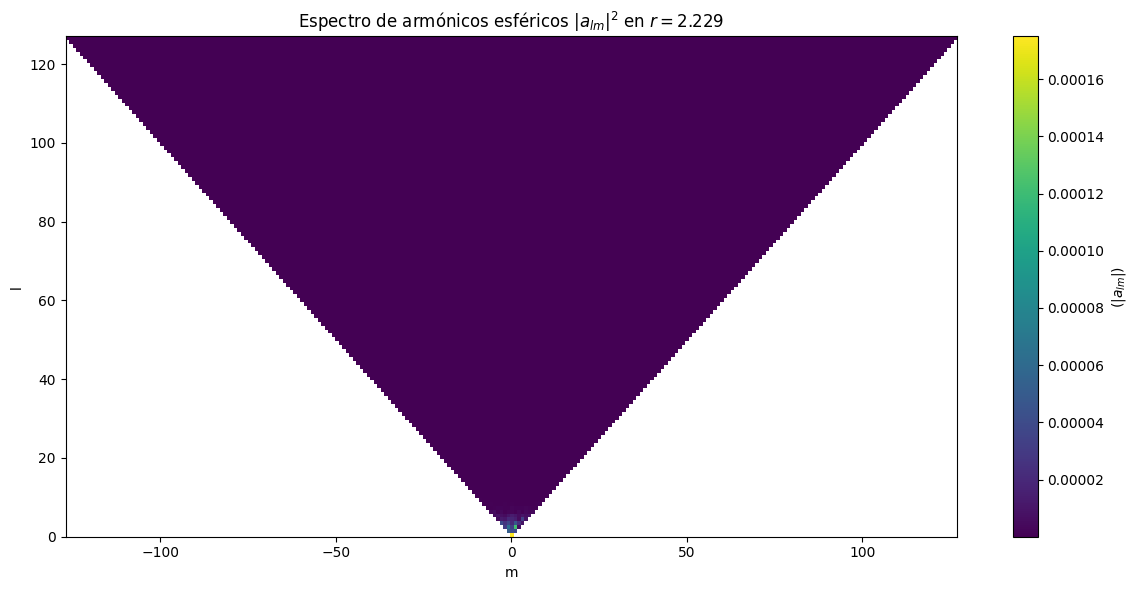

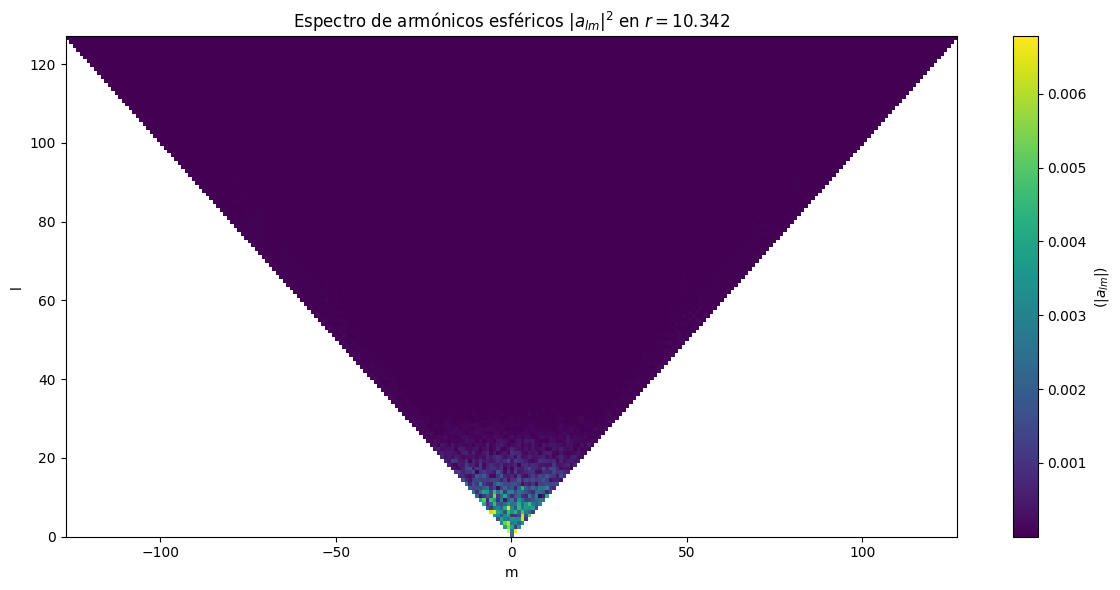

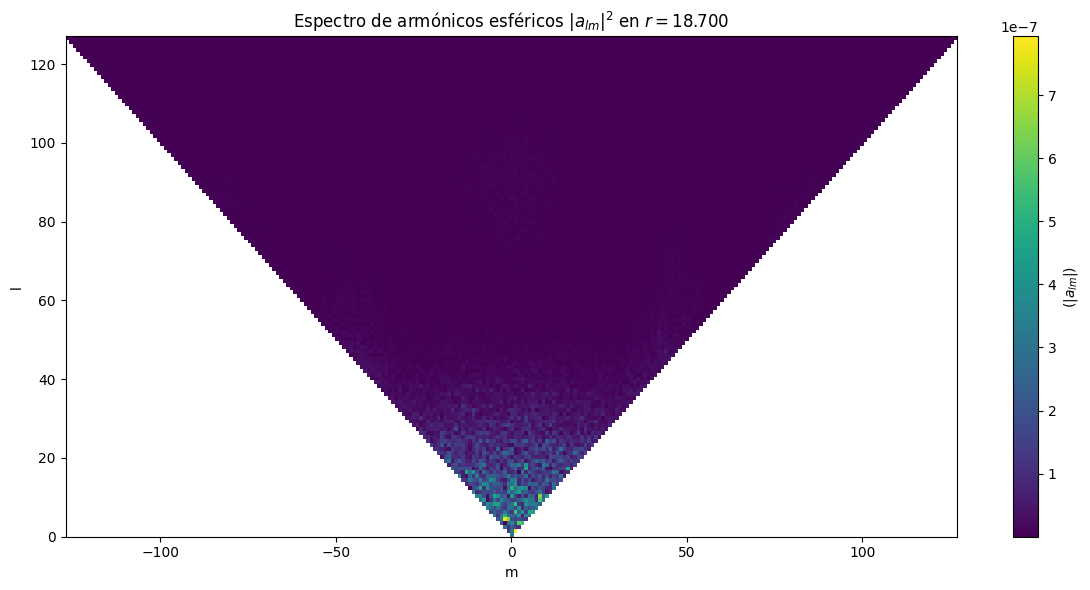

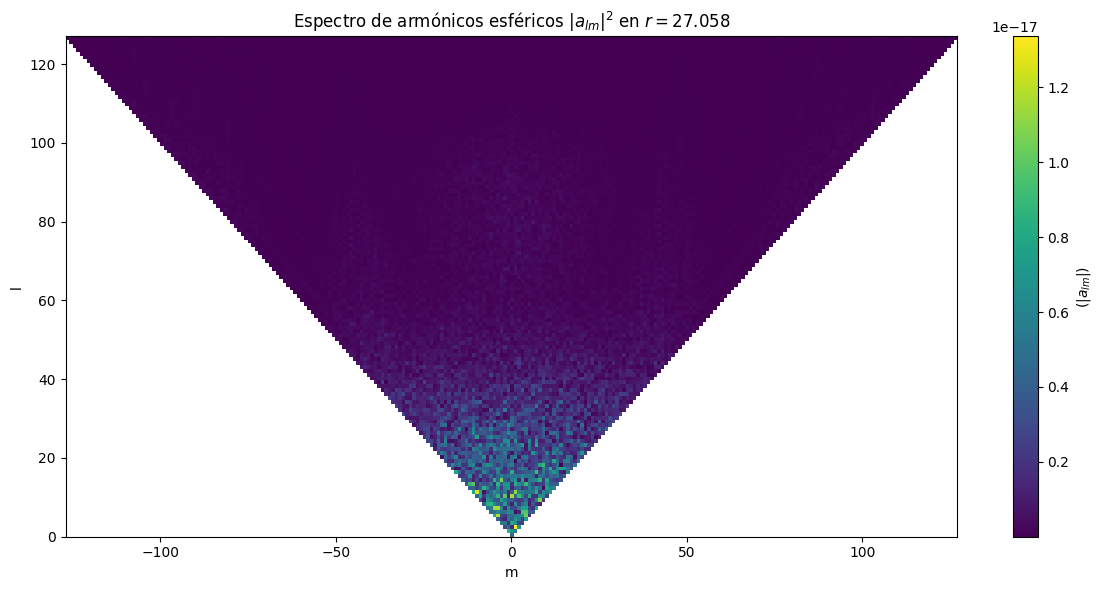

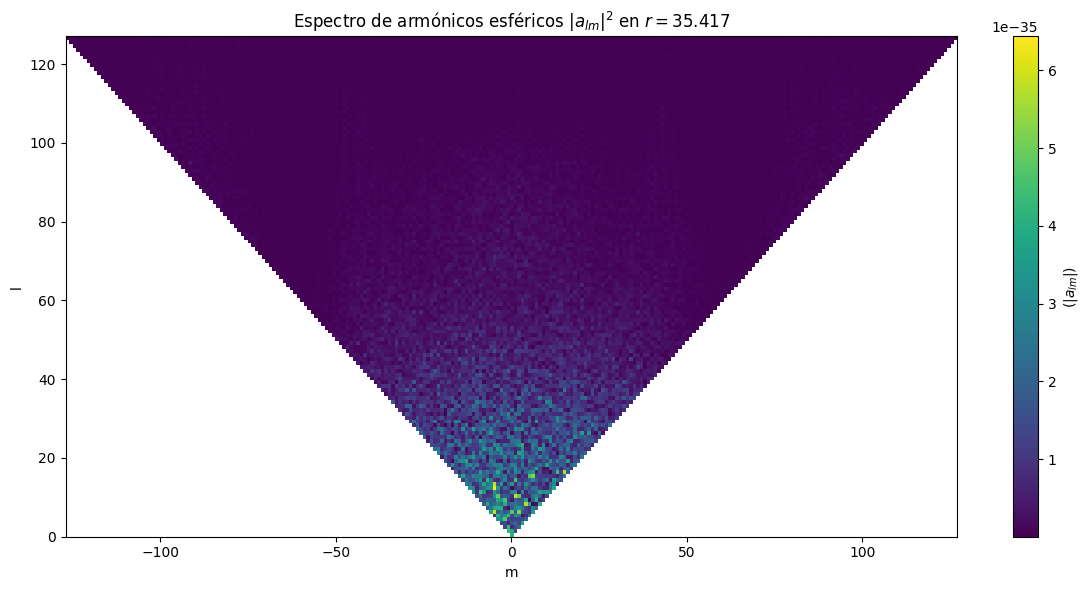

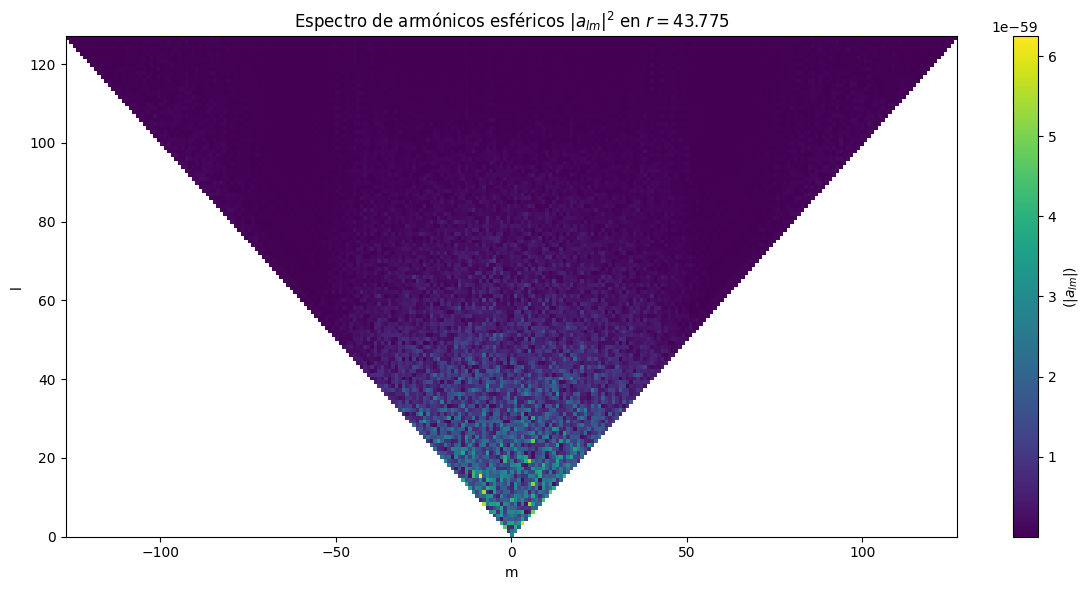

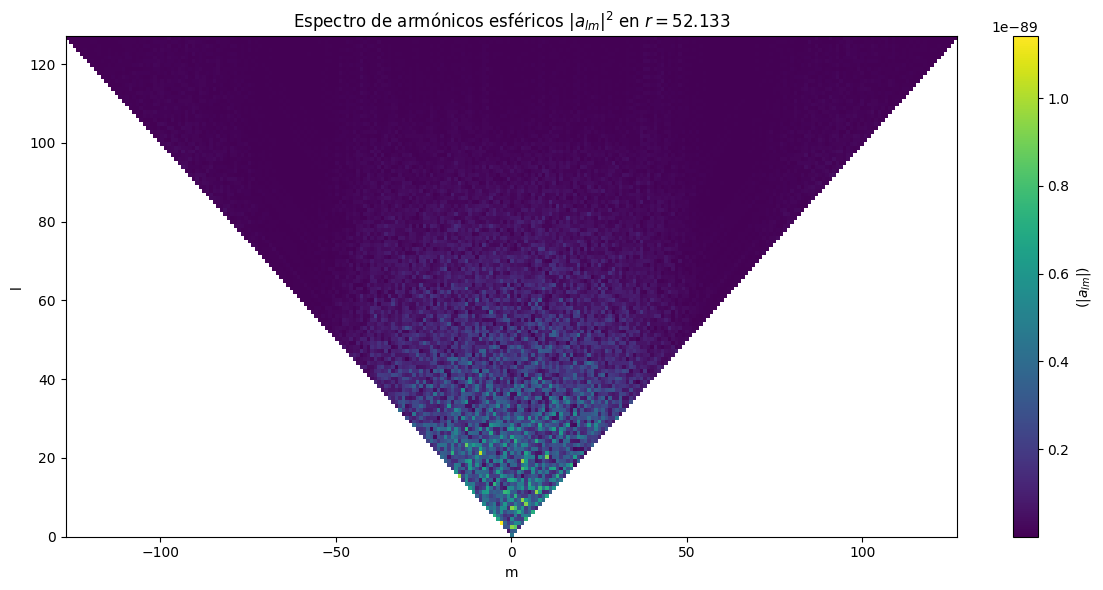

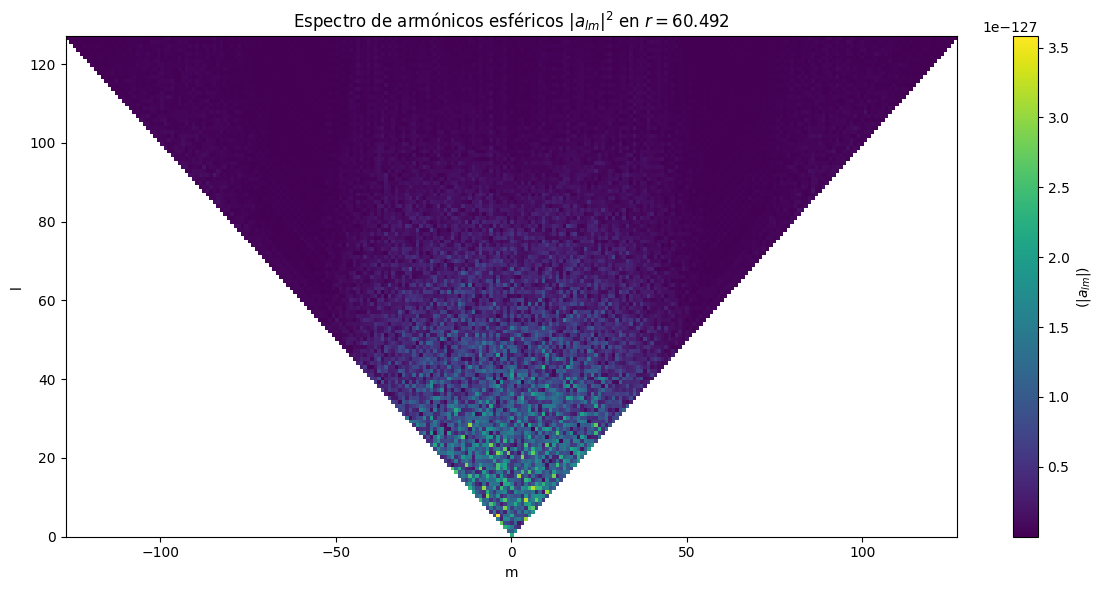

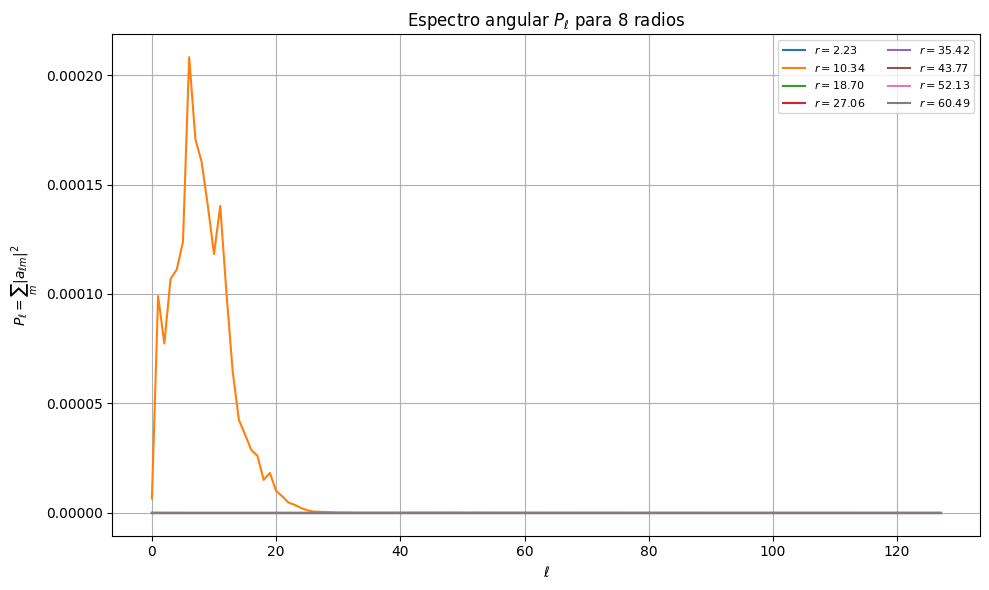

In [33]:
import numpy as np
from scipy.special import sph_harm
from scipy.interpolate import RegularGridInterpolator
from scipy.integrate import trapezoid as trapz
import matplotlib.pyplot as plt
import h5py
from concurrent.futures import ProcessPoolExecutor

# === Configuración ===
filename_real = '/home/flavio/Codes/KG/main/exe/test_6/rePhi.h5'
filename_imag = '/home/flavio/Codes/KG/main/exe/test_6/imPhi.h5'
groupname = '/refinement_1'
i_snapshot = 0

# Nueva resolución angular
Ntheta_new = 256
Nphi_new = 256

# === Leer coordenadas ===
with h5py.File(filename_real, 'r') as f:
    g = f[groupname]
    r = g["Xcoord"][:].transpose()[:, 0, 0]
    theta = g["Ycoord"][:].transpose()[0, :, 0]
    phi = g["Zcoord"][:].transpose()[0, 0, :]

# Eliminar duplicados en r
r_unique, r_indices = np.unique(r, return_index=True)
Nr = len(r_unique) - 1
print(f"Minimo r: {r_unique[0]:.3f}, Máximo r: {r_unique[-1]:.3f}")
print(f"Cantidad de radios únicos: {Nr}")
print(f"Mínimo theta: {theta[0]:.3f}, Máximo theta: {theta[-1]:.3f}")
print(f"Cantidad de puntos theta: {len(theta)}")
print(f"Mínimo phi: {phi[0]:.3f}, Máximo phi: {phi[-1]:.3f}")
print(f"Cantidad de puntos phi: {len(phi)}")

# === Leer campo complejo y reordenar a (r, theta, phi) ===
with h5py.File(filename_real, 'r') as f:
    phi_real = f[groupname][f"rePhi_{i_snapshot}"][:].transpose()
with h5py.File(filename_imag, 'r') as f:
    phi_imag = f[groupname][f"imPhi_{i_snapshot}"][:].transpose()

phi_data = phi_real + 1j * phi_imag
phi_data = phi_data[r_indices, :, :]  # aplicar filtro en r
print(phi_data.shape)  # Verificar dimensiones del campo

# === Crear nueva malla angular y coordenadas ===
theta_new = np.linspace(0, np.pi, Ntheta_new + 1)
phi_new = np.linspace(0, 2 * np.pi, Nphi_new + 1,  endpoint=False)
r_interp = r_unique  # usamos mismos valores en r

# === Interpolación del campo en la nueva malla ===
interp_real = RegularGridInterpolator((r_unique, theta, phi), phi_data.real, bounds_error=False, fill_value=0.0)
interp_imag = RegularGridInterpolator((r_unique, theta, phi), phi_data.imag, bounds_error=False, fill_value=0.0)

print("Interpolando campo en malla regular (r, θ, φ)...")
R, Theta, Phi = np.meshgrid(r_interp, theta_new, phi_new, indexing='ij')
print(f"points R: {len(R.ravel())}, Theta: {len(Theta.ravel())}, Phi: {len(Phi.ravel())}")
points = np.stack([R.ravel(), Theta.ravel(), Phi.ravel()], axis=-1)
phi_interp_flat = interp_real(points) + 1j * interp_imag(points)
phi_data_interp = phi_interp_flat.reshape((len(r_interp), len(theta_new), len(phi_new)))
print("Interpolación completada.")

# === Parámetros ===
Nr = phi_data_interp.shape[0]
Ntheta = len(theta_new)
Nphi = len(phi_new)
l_max = int(min(Ntheta - 2, Nphi/2 - 1))
i_r = np.linspace(5, Nr - 1, 8, dtype=int)

print(i_r)

def calcular_alm_para_radio(args):
    ir, phi_data_interp, theta_new, phi_new, l_max = args
    Ntheta = len(theta_new)
    Nphi = len(phi_new)
    phi_grid, theta_grid = np.meshgrid(phi_new, theta_new, indexing='xy')
    alm = np.zeros((l_max+1, 2*l_max+1), dtype=complex)
    for l in range(l_max+1):
        print(f"  Calculando l = {l} para r = {r_interp[ir]:.3f}...")
        for m in range(-l, l+1):
            ylm = sph_harm(m, l, phi_grid, theta_grid)
            integrando = phi_data_interp[ir, :, :] * np.conj(ylm) * np.sin(theta_grid)
            alm[l, m + l_max] = trapz(trapz(integrando, phi_new, axis=1), theta_new, axis=0)
            #if(ir==72) : print(f"alm[{l},{m}] = {alm[l, m+l_max]}")

         #   if abs(alm[l, m+l_max]) < 1e-10:
         #       alm[l, m+l_max] = 1.e-10 + 0j  # Evitar valores muy pequeños
    # Construye la matriz triangular de |a_lm|^2
    spec = np.full((l_max+1, 2*l_max+1), np.nan)
    for l in range(l_max+1):
        for m in range(-l, l+1):
            spec[l, m+l_max] = np.abs(alm[l, m+l_max])
    # Espectro angular total
    P_l = np.zeros(l_max + 1)
    for l in range(l_max + 1):
        P_l[l] = np.sum(np.abs(alm[l, l_max - l:l_max + l + 1])**2)
    return alm, P_l, spec

# Empaqueta los argumentos para cada radio
args_list = [(int(ir), phi_data_interp, theta_new, phi_new, l_max) for ir in i_r]

Pl_all = []
alm_all = []

print("Procesando radios en paralelo...")
with ProcessPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(calcular_alm_para_radio, args_list))

for idx, (alm, P_l, spec) in enumerate(results):
    Pl_all.append(P_l)
    alm_all.append(alm)
    plt.figure(figsize=(12, 6))
    im = plt.imshow(spec, origin='lower', aspect='auto',
                    extent=[-l_max, l_max, 0, l_max], cmap='viridis')
    plt.colorbar(im, label=r'$(|a_{lm}|)$')
    plt.xlabel('m')
    plt.ylabel('l')
    plt.title(r'Espectro de armónicos esféricos $|a_{{lm}}|^2$ en $r = {:.3f}$'.format(r_interp[i_r[idx]]))
    plt.tight_layout()
    plt.show()

# === Graficar espectros P_l ===
plt.figure(figsize=(10, 6))
for i, P_l in enumerate(Pl_all):
    plt.plot(np.arange(l_max + 1), P_l, label=f"$r = {r_interp[i_r[i]]:.2f}$")
plt.xlabel(r"$\ell$")
plt.ylabel(r"$P_\ell = \sum_m |a_{\ell m}|^2$")
plt.title(f"Espectro angular $P_\\ell$ para {len(i_r)} radios")
plt.legend(fontsize=8, loc='upper right', ncol=2)
plt.grid(True)
plt.tight_layout()
plt.show()